In [1]:
import sys
sys.path.append("creation_functions")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from creation_functions.utilities import create_time_series, get_some_filter
from creation_functions.visualization import have_a_look_at

In [3]:
ACTIVITY_CODES = ["dws", "jog", "sit", "std", "ups", "wlk"]

TRIAL_CODES = {
    ACTIVITY_CODES[0]:[1,2,11],
    ACTIVITY_CODES[1]:[9,16],
    ACTIVITY_CODES[2]:[5,13],
    ACTIVITY_CODES[3]:[6,14],
    ACTIVITY_CODES[4]:[3,4,12],
    ACTIVITY_CODES[5]:[7,8,15]
}

ACTORS = np.linspace(1, 24, 24).astype(int)

### Step 1: We load the dataset and we take a first look at sample
In this first phase of pre-processing we want take a look at two datasets:
- The "raw" _MotionSense_, from which we select a subset of the sensors used in the original experiment; in particular, we dropped the "attitude" sensor because we have too much different sensors in our phone. So, thinking about comparing the entire work with some personal experiments, we decided to leave it out.
- The "collapsed" dataaset, which is the version in which each group of samples has been collapsed in a single row during the feature extraction process.

_A Note_: To have a look at how feature extraction has been performed, please open the **feature_extraction_and_selection**

In [4]:
raw_dataset = create_time_series(mode="raw")

First of all we want to plot some windows of the raw dataset to show that activities have different shapes.

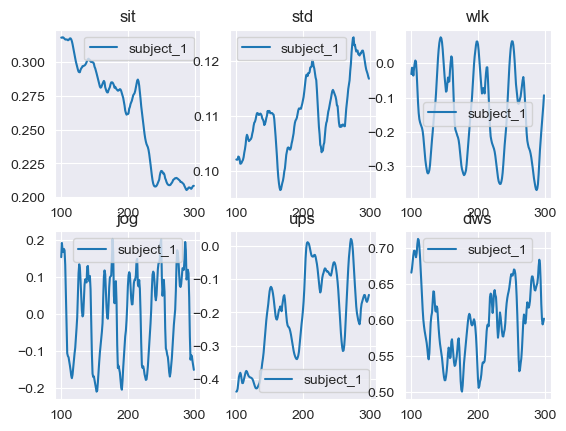

In [5]:
fig, ax = plt.subplots(2, 3)
have_a_look_at(raw_dataset, ["sit"], ["gravity.x"], ax[0][0], actors=[1])
have_a_look_at(raw_dataset, ["std"], ["gravity.x"], ax[0][1], actors=[1])
have_a_look_at(raw_dataset, ["wlk"], ["gravity.x"], ax[0][2], actors=[1])
have_a_look_at(raw_dataset, ["jog"], ["gravity.x"], ax[1][0], actors=[1])
have_a_look_at(raw_dataset, ["ups"], ["gravity.x"], ax[1][1], actors=[1])
have_a_look_at(raw_dataset, ["dws"], ["gravity.x"], ax[1][2], actors=[1])

Anyway, we need to handle with the fact that subjects are not all equal, and so we could have bad performance if we don't care about it.

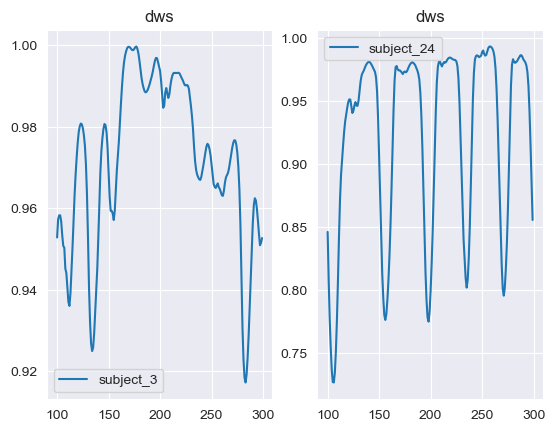

In [6]:
fig, ax = plt.subplots(1, 2)
have_a_look_at(raw_dataset, ["dws"], ["gravity.y"], ax[0], actors=[3])
have_a_look_at(raw_dataset, ["dws"], ["gravity.y"], ax[1], actors=[24])

In [7]:
raw_dataset.isna().sum()

gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
class                 0
subject               0
trial                 0
dtype: int64

The raw_dataset is not affected by NaN values. That's a good thing, but we are not sure that during feature extraction things will not change.
Before proceeding, we want to put the focus on the fact that noise are reduced during feature extraction with a filter. Details on which filter we have used are discussed at the end of this notebook.

In [8]:
collapsed_dataset = create_time_series()

In [9]:
collapsed_dataset.isna().sum().sort_values()

gravity.x_mean             0
userAcceleration.xX#3      0
userAcceleration.xX#2      0
userAcceleration.xX#1      0
rotationRate.zP#3          0
                        ... 
gravity.xX#5             277
gravity.yX#5             338
gravity.yP#5             338
gravity.zX#5             352
gravity.zP#5             352
Length: 147, dtype: int64

<AxesSubplot: >

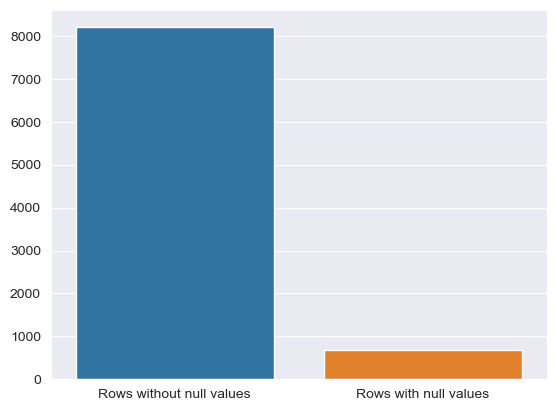

In [10]:
rows_not_null = collapsed_dataset.dropna().shape[0]
rows_null = collapsed_dataset.shape[0]-collapsed_dataset.dropna().shape[0]
sns.barplot(x=["Rows without null values", "Rows with null values"], y=[rows_not_null, rows_null])

In [11]:
df_rows_null=pd.DataFrame(collapsed_dataset.isna().sum())
df_rows_null=df_rows_null.rename(columns={df_rows_null.columns[0]:'count'}).sort_values("count", ascending=False)
df_rows_null= df_rows_null.loc[(df_rows_null != 0).any(axis=1)]
df_rows_null


,count
gravity.zX#5,352
gravity.zP#5,352
gravity.yP#5,338
gravity.yX#5,338
gravity.xX#5,277
gravity.xP#5,277
gravity.yP#4,204
gravity.yX#4,204
gravity.zX#4,200
gravity.zP#4,200


As we can see **all** of the null values comes from the gravity sensor when computing peaks in frequency. We're going to explain this later. We're going to substitute them with the mean of the column of objects belonging to the same class.

In [12]:
collapsed_dataset = collapsed_dataset.fillna(collapsed_dataset.groupby('class').transform('mean'))
collapsed_dataset.isna().sum()

gravity.x_mean           0
gravity.x_std            0
gravity.x_range          0
gravity.x_IRQ            0
gravity.x_kurtosis       0
                        ..
userAcceleration.zP#4    0
userAcceleration.zP#5    0
class                    0
subject                  0
trial                    0
Length: 147, dtype: int64

In [13]:
raw_dataset

,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,class,subject,trial
0,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws,1,1
1,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws,1,1
2,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws,1,1
3,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws,1,1
4,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,dws,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2055,-0.365012,0.924904,-0.106393,1.446270,2.409207,-1.052698,0.034354,-0.574501,0.060144,wlk,24,15
2056,-0.373942,0.917131,-0.137981,0.602010,2.675064,-0.472482,0.547953,-0.481645,-0.232273,wlk,24,15
2057,-0.347061,0.919606,-0.184047,1.125564,4.413143,1.581002,0.910034,0.194606,-0.770222,wlk,24,15
2058,-0.303291,0.929562,-0.209592,0.086910,0.436147,1.762577,0.811333,0.424518,-0.716784,wlk,24,15


In [14]:
collapsed_dataset

,gravity.x_mean,gravity.x_std,gravity.x_range,gravity.x_IRQ,gravity.x_kurtosis,gravity.x_skewness,gravity.y_mean,gravity.y_std,gravity.y_range,gravity.y_IRQ,...,userAcceleration.zX#4,userAcceleration.zX#5,userAcceleration.zP#1,userAcceleration.zP#2,userAcceleration.zP#3,userAcceleration.zP#4,userAcceleration.zP#5,class,subject,trial
0,0.660836,0.055586,0.243333,0.065299,-0.262111,-0.253176,0.697236,0.062177,0.300027,0.083480,...,0.001733,0.002133,13.807348,10.305709,10.737154,7.903655,6.034663,dws,1,1
0,0.591719,0.045982,0.182260,0.076077,-0.953223,-0.036783,0.763231,0.049877,0.195841,0.071596,...,0.002133,0.002533,5.954942,11.828021,8.168617,3.514331,6.316686,dws,1,1
0,0.616612,0.050241,0.217641,0.058887,-0.386998,-0.047354,0.765423,0.042016,0.159486,0.060085,...,0.001867,0.002267,4.205105,13.926414,10.132591,7.850723,4.440575,dws,1,1
0,0.819881,0.062960,0.250333,0.052232,0.824574,-1.283976,0.522868,0.095616,0.371295,0.119794,...,0.001333,0.001600,5.260687,5.717704,9.357244,3.591812,3.649510,dws,1,1
0,0.850191,0.031659,0.119984,0.046023,-0.952690,-0.160122,0.480892,0.059932,0.240709,0.076645,...,0.001600,0.001867,7.168658,21.722648,4.473481,7.613701,5.723588,dws,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.122797,0.276033,0.808953,0.532103,-1.487179,0.271106,0.918917,0.030907,0.133196,0.040983,...,0.001467,0.001867,8.398322,23.333486,16.774102,19.093016,18.715154,wlk,24,15
0,-0.074504,0.269702,0.823917,0.509042,-1.412785,0.323312,0.924469,0.036752,0.150159,0.045857,...,0.001467,0.001867,2.715984,28.300697,19.680617,24.616760,20.037615,wlk,24,15
0,-0.039299,0.269917,0.810115,0.499819,-1.401116,0.319121,0.927167,0.040061,0.148042,0.045022,...,0.001467,0.001867,4.697057,23.213458,15.414131,17.698143,17.489799,wlk,24,15
0,-0.043965,0.299500,0.915244,0.572758,-1.464768,0.187227,0.910849,0.048021,0.187299,0.063320,...,0.001467,0.001867,8.323046,22.765793,11.518568,18.601501,16.335227,wlk,24,15


In [15]:
raw_dataset.to_csv("raw_dataset.csv")
collapsed_dataset.to_csv("collapsed_dataset.csv")

In [16]:
raw_dataset = pd.read_csv("raw_dataset.csv", index_col=0)
collapsed_dataset = pd.read_csv("collapsed_dataset.csv", index_col=0)

[Text(0.5, 1.0, 'Class Distribution (Collapsed Data)')]

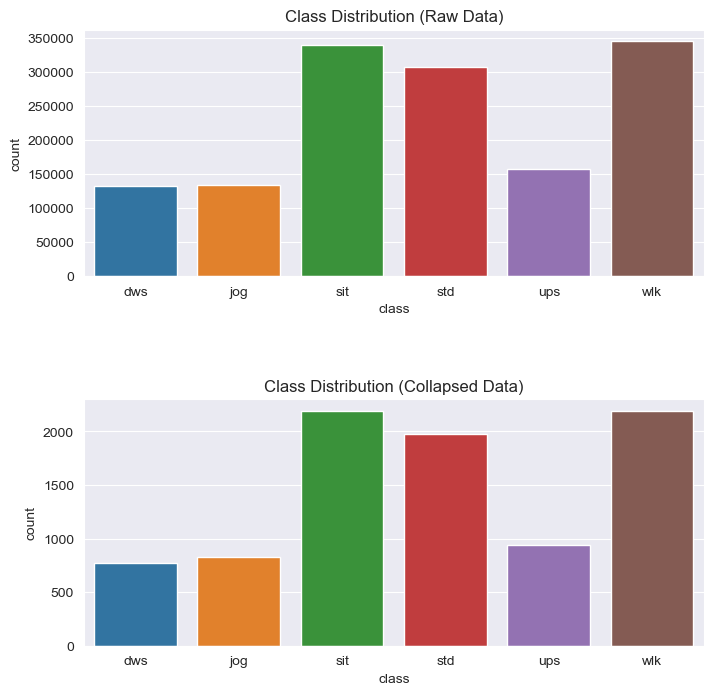

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8,8))
plt.subplots_adjust(hspace = 0.5)
sns.countplot(x="class",data=raw_dataset, ax=axes[0]).set(title="Class Distribution (Raw Data)")
sns.countplot(x="class", data=collapsed_dataset, ax=axes[1]).set(title="Class Distribution (Collapsed Data)")

In [18]:
# Have a look a some signals for sitting
ACTIVITY_CODES_s = ["sit"]
TRIAL_CODES_s = { ACTIVITY_CODES_s[0]:[13]}
sitting_subjects = get_some_filter(raw_dataset,[5, 6, 7, 8, 9, 10], ["sit"])
sitting_subjects = sitting_subjects.loc[sitting_subjects["trial"] == 13]

Text(0.5, 1.0, 'Different lenght of Trial 13 (Sitting) for some subjects')

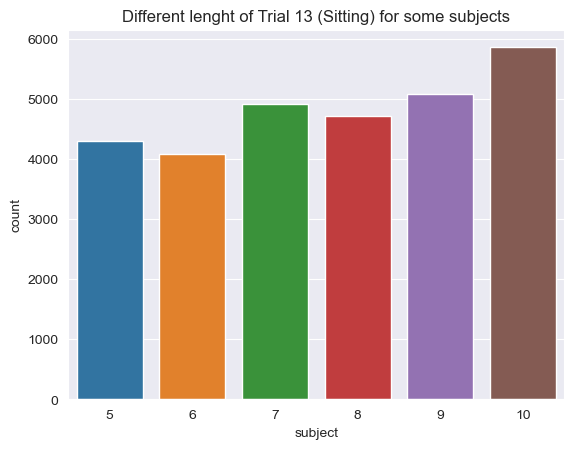

In [19]:
# Trials seem to have different duration
sns.countplot(x="subject", data=sitting_subjects)
plt.title("Different lenght of Trial 13 (Sitting) for some subjects")

In [20]:
collapsed_dataset["subject"].value_counts().sort_index()

1     392
2     395
3     395
4     352
5     327
6     361
7     386
8     383
9     359
10    375
11    372
12    332
13    320
14    355
15    372
16    415
17    347
18    397
19    457
20    346
21    436
22    349
23    342
24    317
Name: subject, dtype: int64

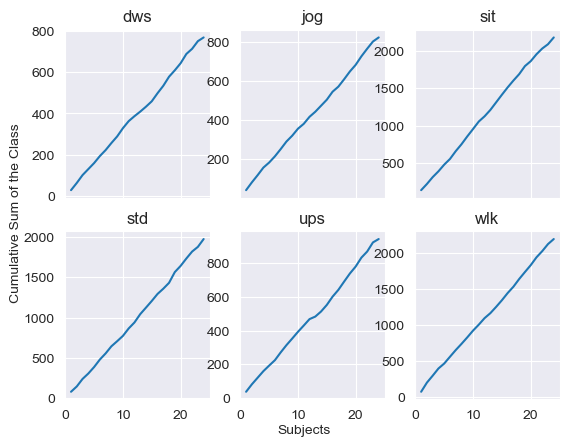

In [21]:
fig, axes = plt.subplots(2, 3, sharex=True)
index = 0
fig.text(0.5, 0.04, 'Subjects', ha='center')
fig.text(0.04, 0.5, 'Cumulative Sum of the Class', va='center', rotation='vertical')
for act in ACTIVITY_CODES:
    length_act = get_some_filter(collapsed_dataset, ACTORS, [act])["subject"].value_counts().sort_index()
    axes[int(index/3)][index%3].plot(np.cumsum(length_act))
    axes[int(index/3)][index%3].set_title(str(act))
    index += 1

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.x')

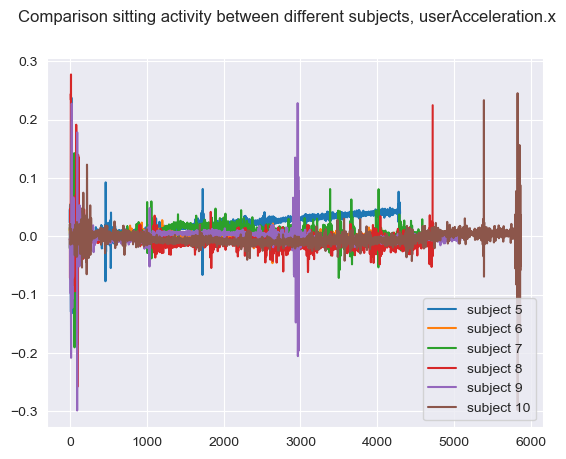

In [22]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.x"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.x")

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.y')

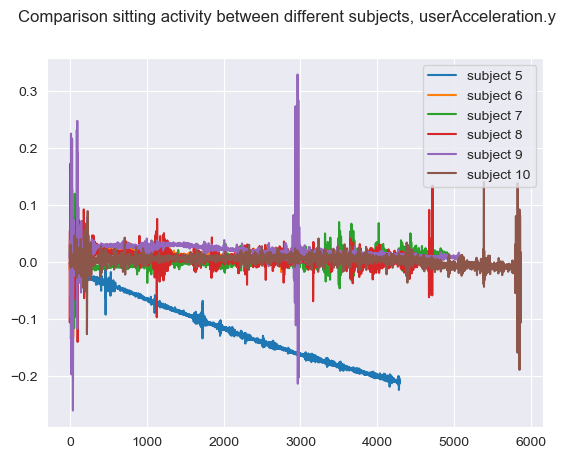

In [23]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.y"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.y")

Text(0.5, 0.98, 'Comparison sitting activity between different subjects, userAcceleration.z')

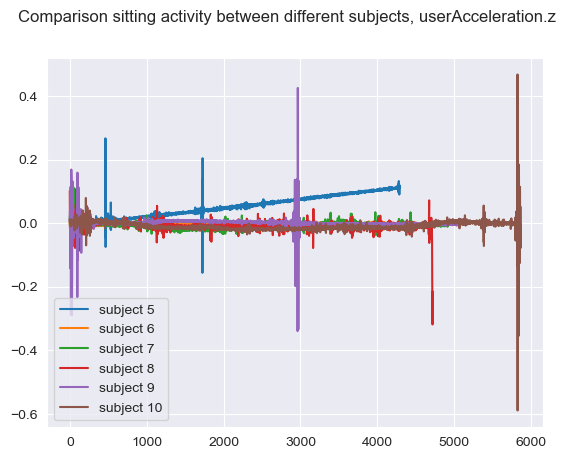

In [24]:
labels = ["subject 5", "subject 6", "subject 7", "subject 8", "subject 9", "subject 10"]
for i in [5, 6, 7, 8, 9, 10]:
    plt.plot(sitting_subjects.loc[sitting_subjects["subject"] == i]["userAcceleration.z"])
plt.legend(labels)
plt.suptitle("Comparison sitting activity between different subjects, userAcceleration.z")

#### What do we learn from this exploratory data analysis:
- First, both raw dataset doesn't have any NaN value, while collapsed dataset has. To remove NaN values coming from computation of frequency peaks of the gravity sensor, we substitute them with the mean of the column, grouping by activity.
- Secondly, we noticed that the class distribution is a bit unbalanced, with (for example), "jogging" having < 50% of walking class. We have seen that trials have different length, and so It has been this fact that lead the dataset to be unbalanced.
- Thirdly, we wanted to know if some actors contributed differently between each other in class counting, but the plotting of the cumulative sum varying subjects proves that each subject contributed more or less equally in that. That's a good news, looking for a custom cross validation that involves the division in subjects instead of the entire dataset.

Moreover, we discovered that **subject 5** had a really strange behaviur during trial 13 (sitting).

### Step 2: Data Cleaning
We already stated that now there's no NaN value, so in this phase we want to determine:
- What type of smoothing, if necessary, we should use
- _Dimensionality Reduction_ : we want to state if some attributes are "too much" correlated, and so try to understand if we chan chop out some of them.

_A note_: We decided to perform the task of having a sight on correlation *before* feature extraction. In this manner, we expect to have better results later.

In [25]:
from scipy.signal import savgol_filter

# Here we have a template for the real function we are putting in .py file
def noise_filter(data, k=10, pol=2):
    dataframe = data.copy()
    for column in dataframe.columns:
        dataframe[column] = savgol_filter(dataframe[column], k, pol, axis=0)
    return dataframe

In [26]:
little_test = get_some_filter(raw_dataset, [5], ["jog"])
little_test = little_test.loc[little_test["trial"] == 9][100:250]
little_test.drop(["subject", "trial", "class"], axis=1, inplace=True)

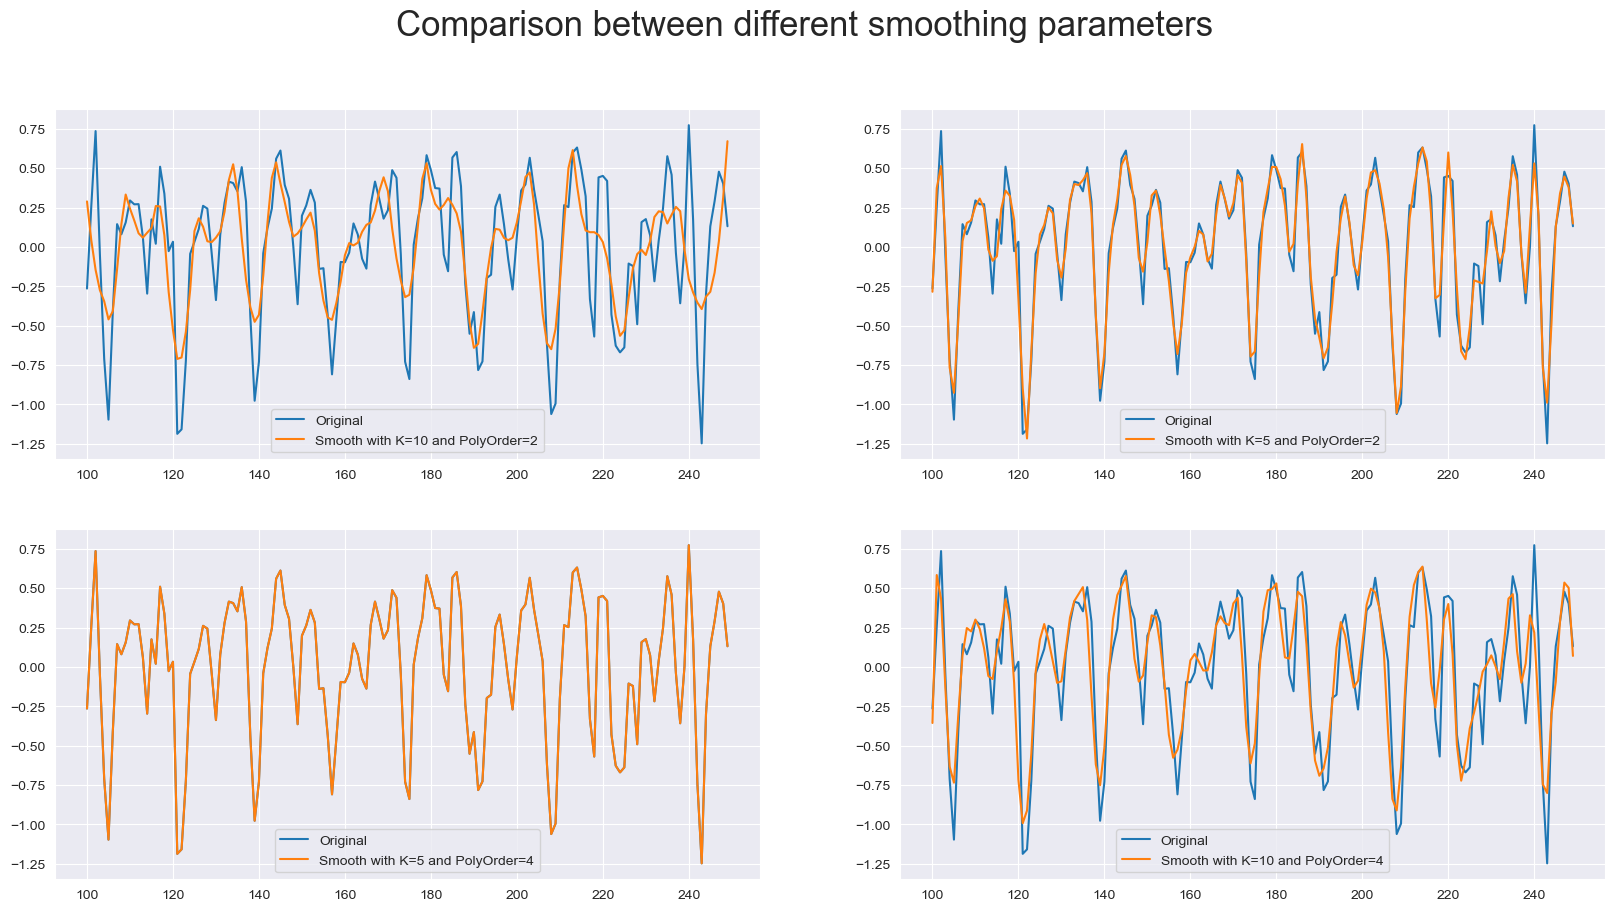

In [27]:
f, axes=plt.subplots(2,2,figsize=(20,10))
f.suptitle("Comparison between different smoothing parameters", fontsize=25)

axes[0][0].plot(little_test["userAcceleration.x"])
axes[0][0].plot(noise_filter(little_test)["userAcceleration.x"])
axes[0][0].legend(["Original", "Smooth with K=10 and PolyOrder=2"])

axes[0][1].plot(little_test["userAcceleration.x"])
axes[0][1].plot(noise_filter(little_test, k=5, pol=2)["userAcceleration.x"])
axes[0][1].legend(["Original", "Smooth with K=5 and PolyOrder=2"])

axes[1][0].plot(little_test["userAcceleration.x"])
axes[1][0].plot(noise_filter(little_test, k=5, pol=4)["userAcceleration.x"])
axes[1][0].legend(["Original", "Smooth with K=5 and PolyOrder=4"])

axes[1][1].plot(little_test["userAcceleration.x"])
axes[1][1].plot(noise_filter(little_test, k=10, pol=4)["userAcceleration.x"])
axes[1][1].legend(["Original", "Smooth with K=10 and PolyOrder=4"])

We chose to filter K = 5 and PolyOrder = 2, to have a not so high smooth ratio and preserve qualitatively the true height of peaks

Before continuing, we decided to drop trial 13 (sitting) of subject 5 because, as we have seen above, it has some errors inside

In [28]:
new_dataset = collapsed_dataset.loc[(collapsed_dataset["subject"] != 5) | (collapsed_dataset["trial"] != 13)]

In [29]:
new_dataset.loc[new_dataset["subject"] == 5]

,gravity.x_mean,gravity.x_std,gravity.x_range,gravity.x_IRQ,gravity.x_kurtosis,gravity.x_skewness,gravity.y_mean,gravity.y_std,gravity.y_range,gravity.y_IRQ,...,userAcceleration.zX#4,userAcceleration.zX#5,userAcceleration.zP#1,userAcceleration.zP#2,userAcceleration.zP#3,userAcceleration.zP#4,userAcceleration.zP#5,class,subject,trial
0,-0.289830,0.226426,0.704363,0.417637,-1.372925,-0.376255,0.868527,0.152399,0.531122,0.172716,...,0.001333,0.001733,2.968535,2.598477,1.233439,1.763071,2.979524,dws,5,1
0,-0.165888,0.030535,0.128853,0.037837,-0.387046,0.737429,0.929478,0.030884,0.123488,0.036403,...,0.001733,0.002133,8.261162,6.298424,4.233188,2.971189,4.073346,dws,5,1
0,-0.092372,0.072743,0.276370,0.107015,-0.736785,0.445183,0.952892,0.031316,0.125940,0.040524,...,0.002000,0.002267,7.569587,6.711469,5.635717,4.494225,3.446523,dws,5,1
0,-0.184347,0.049456,0.188224,0.058932,-0.247531,0.842734,0.932922,0.037015,0.155486,0.039442,...,0.001867,0.002400,4.248799,8.714606,4.120845,4.017818,2.459624,dws,5,1
0,-0.147812,0.069690,0.281836,0.085080,0.468821,1.043639,0.940524,0.032636,0.132135,0.045047,...,0.001600,0.002133,3.011105,5.530326,9.390683,6.183272,3.371718,dws,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.026650,0.110039,0.427625,0.146982,-0.438408,0.764940,0.974279,0.024260,0.085341,0.021540,...,0.001600,0.001867,1.398616,16.018837,11.825195,14.432981,4.356729,wlk,5,15
0,-0.048572,0.094243,0.351222,0.140416,-0.566538,0.721720,0.973354,0.024795,0.095067,0.023648,...,0.001600,0.002000,4.589793,13.476633,11.549200,14.940509,1.656792,wlk,5,15
0,-0.012006,0.121786,0.385530,0.202586,-0.981630,0.712631,0.965434,0.033957,0.105986,0.051866,...,0.002000,0.002267,14.556902,8.237881,17.287672,3.402989,2.802149,wlk,5,15
0,-0.026145,0.112539,0.367521,0.171501,-0.838014,0.744233,0.965330,0.037337,0.128579,0.046488,...,0.001600,0.001867,3.398486,13.405442,6.827431,13.631631,3.196750,wlk,5,15


In [30]:
only_numeric_dataset = new_dataset.drop(["trial", "subject"], axis=1)
only_numeric_dataset.corr()

,gravity.x_mean,gravity.x_std,gravity.x_range,gravity.x_IRQ,gravity.x_kurtosis,gravity.x_skewness,gravity.y_mean,gravity.y_std,gravity.y_range,gravity.y_IRQ,...,userAcceleration.zX#1,userAcceleration.zX#2,userAcceleration.zX#3,userAcceleration.zX#4,userAcceleration.zX#5,userAcceleration.zP#1,userAcceleration.zP#2,userAcceleration.zP#3,userAcceleration.zP#4,userAcceleration.zP#5
gravity.x_mean,1.000000,0.016561,0.009314,0.017947,0.019553,-0.046478,-0.128776,0.015220,0.013144,0.031743,...,0.022229,0.013905,0.004735,0.010453,0.014824,-0.039695,-0.074237,-0.063265,-0.044711,-0.012894
gravity.x_std,0.016561,1.000000,0.984155,0.978484,-0.238208,-0.059712,0.309818,0.655430,0.675386,0.601187,...,-0.079352,-0.116092,-0.113880,-0.109952,-0.106300,0.511614,0.555489,0.546274,0.509989,0.547215
gravity.x_range,0.009314,0.984155,1.000000,0.935004,-0.189496,-0.065203,0.328926,0.671099,0.700087,0.604587,...,-0.077896,-0.120234,-0.117867,-0.114838,-0.111112,0.548941,0.591850,0.581149,0.546168,0.581500
gravity.x_IRQ,0.017947,0.978484,0.935004,1.000000,-0.294010,-0.042182,0.285499,0.626957,0.638324,0.588997,...,-0.078436,-0.108513,-0.105939,-0.100439,-0.097628,0.483969,0.520769,0.513465,0.477602,0.518145
gravity.x_kurtosis,0.019553,-0.238208,-0.189496,-0.294010,1.000000,-0.028357,-0.130751,-0.160395,-0.147186,-0.179219,...,0.057651,0.089485,0.097008,0.094869,0.100036,-0.123612,-0.149925,-0.136382,-0.127872,-0.133528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
userAcceleration.zP#1,-0.039695,0.511614,0.548941,0.483969,-0.123612,-0.022135,0.241560,0.458531,0.483685,0.418591,...,0.071110,0.063128,0.059776,0.058962,0.050528,1.000000,0.643526,0.802744,0.745531,0.698021
userAcceleration.zP#2,-0.074237,0.555489,0.591850,0.520769,-0.149925,-0.035172,0.312119,0.505781,0.517634,0.499143,...,-0.148744,-0.178209,-0.162076,-0.174390,-0.169491,0.643526,1.000000,0.802055,0.819984,0.744747
userAcceleration.zP#3,-0.063265,0.546274,0.581149,0.513465,-0.136382,-0.037677,0.282332,0.463619,0.478911,0.449240,...,-0.070332,-0.098292,-0.081889,-0.065920,-0.068090,0.802744,0.802055,1.000000,0.807114,0.725182
userAcceleration.zP#4,-0.044711,0.509989,0.546168,0.477602,-0.127872,-0.043008,0.276397,0.455596,0.467522,0.458721,...,-0.108534,-0.133322,-0.137354,-0.125518,-0.108377,0.745531,0.819984,0.807114,1.000000,0.763759


In [31]:
# Create correlation matrix
corr_matrix = only_numeric_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features
to_drop

['gravity.x_range',
 'gravity.x_IRQ',
 'gravity.y_range',
 'gravity.y_IRQ',
 'gravity.z_range',
 'gravity.z_IRQ',
 'rotationRate.x_range',
 'rotationRate.x_IRQ',
 'rotationRate.y_range',
 'rotationRate.y_IRQ',
 'rotationRate.z_range',
 'rotationRate.z_IRQ',
 'userAcceleration.x_range',
 'userAcceleration.x_IRQ',
 'userAcceleration.y_range',
 'userAcceleration.y_IRQ',
 'userAcceleration.z_range',
 'userAcceleration.z_IRQ',
 'gravity.yP#1',
 'gravity.zP#1',
 'rotationRate.xP#1']

In [32]:
only_numeric_dataset_filtered = only_numeric_dataset.drop(to_drop, axis=1)

For seeing how much important it has been to remove highly correlated features, let's perform a primitive feature selection, let's say a SelectKBeast(k=4), and have a look at the feature selected

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder

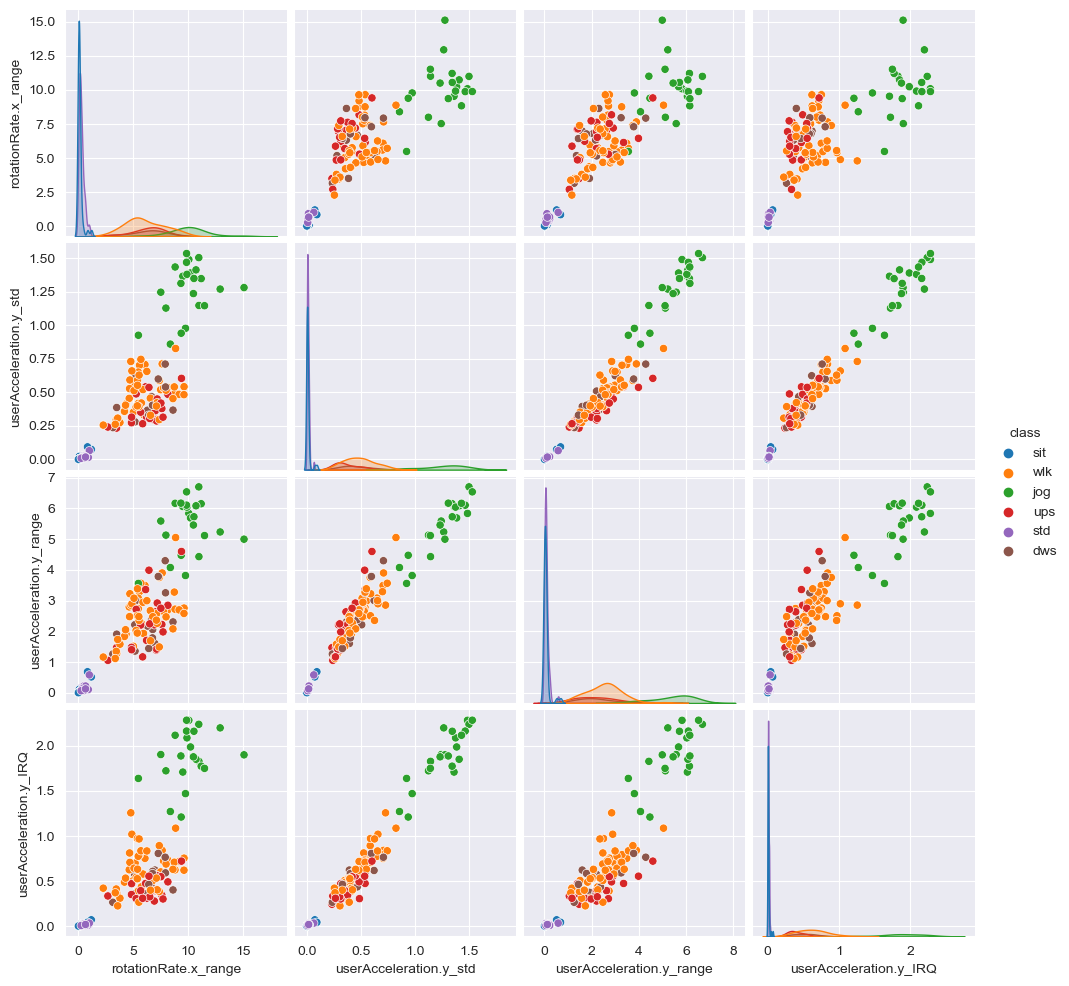

In [34]:
encoder=LabelEncoder()
feature_sel = SelectKBest(k=4).fit(only_numeric_dataset.drop("class", axis=1), encoder.fit_transform(only_numeric_dataset["class"]))
selected_features=feature_sel.get_support(indices=True)
selected_features=np.append(selected_features, 144)

test1 =only_numeric_dataset.iloc[:, selected_features]

sns.pairplot(data=test1.sample(n=200), hue="class")

We can easily notice that userAccelaration.y_std, userAcceleration.y_range, userAcceleration.y_IRQ seem to be highly correlated at a first sight.

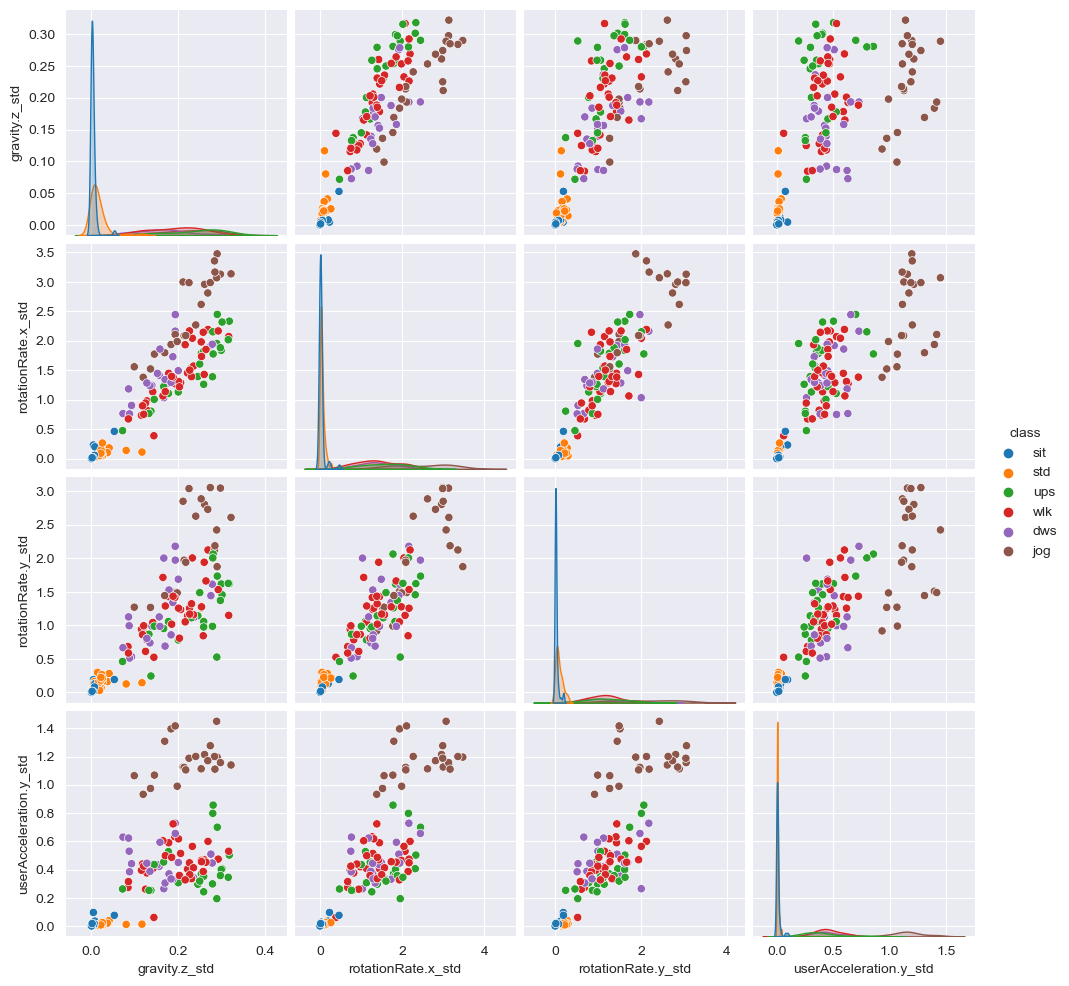

In [35]:
encoder=LabelEncoder()
feature_sel = SelectKBest(k=4).fit(only_numeric_dataset_filtered.drop("class", axis=1), encoder.fit_transform(only_numeric_dataset_filtered["class"]))
selected_features=feature_sel.get_support(indices=True)
selected_features=np.append(selected_features, 123)

test1 =only_numeric_dataset_filtered.iloc[:, selected_features]

sns.pairplot(data=test1.sample(n=200), hue="class")

As we can see, features appear to be more sparse now, and SelectKBest choose more different features.

In [38]:
# Check for duplicates
print(only_numeric_dataset_filtered.shape)
dropped = only_numeric_dataset_filtered.drop_duplicates()
print(dropped.shape)

(8855, 124)
(8788, 124)


### Preprocessing ends here
We have learned a bit of information from data in this second phase. In particular:
- We identified there are some feature extracted that are too similar with others. SelectKBest, a feature selector that doesn't care by default at redudancy, select different features it they are first filtered using a correlation index (we used a correlation threshold of 95%)
- We choosed the number of points of smoothing and the degree of the smoothing function as K = 5 and PolOrder = 2.
- We checked for duplicated after all preprocessing steps.
- All operations are then kept in a python function "preprocessing" for the other notebooks